In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import plotly.express as px
import xgboost as xgb

from model import ModelPipeline
import pickle

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def smape(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

TIME_FORMAT = '%Y-%m-%d'
DROPNA = True
key_columns = ['locus_id', 'fish_group_id', 'transfer_year']

root_path = Path('./data/')

targets_df = pd.read_csv(root_path / 'targets.csv')

mortality = pd.read_csv('../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')
mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
mortality['transport_year']= mortality['transfer_date'].dt.year

tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
img_path = Path('./img')
result_data_path = Path('./result_data')
img_path.mkdir(exist_ok=True)
result_data_path.mkdir(exist_ok=True)

PREDICTIVE_SAVE_PATH = result_data_path / 'predictive' 
PREDICTIVE_SAVE_PATH.mkdir(exist_ok=True)

MODEL_SAVE_PATH = result_data_path / 'predictive' / 'models'
MODEL_SAVE_PATH.mkdir(exist_ok=True)

IMPORTANCE_SAVE_PATH = result_data_path / 'predictive' / 'importance'
IMPORTANCE_SAVE_PATH.mkdir(exist_ok=True)

IMPORTANT_IMG_SAVE_PATH = img_path / 'predictive' / 'importance'
IMPORTANT_IMG_SAVE_PATH.mkdir(exist_ok=True)

## Preprocessing

**Prerequisites**: factors_ranking.ipynb notebook has been run so train_data.csv, test_data.csv exist, as well list of final features

In [3]:
path_train_data = result_data_path / 'split' / 'train_data.csv'
path_test_data = result_data_path / 'split' / 'test_data.csv'
path_features_list = result_data_path / 'factor_ranking' / 'final_features.csv'

train_data = pd.read_csv(path_train_data)
test_data = pd.read_csv(path_test_data)

all_features = train_data.columns.difference(key_columns + ['mortality', 'tgc', 'nsfr']).tolist()
final_features = pd.read_csv(path_features_list)
final_features = final_features['0'].tolist()

In [4]:
display(train_data.head())

display(test_data.head())

,locus_id,fish_group_id,transfer_year,is_baño sin pmv-after_first_feeding-sum,is_baño sin pmv-whole_period-sum,is_bath-after_first_feeding-sum,is_bath-whole_period-sum,is_ipn-whole_period-sum,is_nacl-after_first_feeding-sum,is_saprosafe aw-whole_period-sum,...,atpasa_derivative,k_factor_derivative,length_last,weight_last,light_days_transfer_vaccination,av.light_hours_per_day_vac,number_of_weeks_with_summer_vac_transfer_normalized,mortality,tgc,nsfr
0,3046036,11,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007496,2.699988,0.889235
1,3046036,1052,2019,0.0,0.0,0.627719,0.437630,0.0,0.601108,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003943,3.291903,1.056957
2,3046036,3918,2020,0.0,0.0,0.187821,-0.200753,0.0,0.062448,1.151237,...,0.886353,-0.81477,-0.520123,-0.421624,-1.452722,-0.478418,0.975571,0.007676,2.771383,0.852458
3,3046043,310,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018394,2.747195,0.823061
4,3046043,498,2019,0.0,0.0,0.335355,0.705431,0.0,0.223773,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027014,3.419715,1.058987


,locus_id,fish_group_id,transfer_year,is_baño sin pmv-after_first_feeding-sum,is_baño sin pmv-whole_period-sum,is_bath-after_first_feeding-sum,is_bath-whole_period-sum,is_ipn-whole_period-sum,is_nacl-after_first_feeding-sum,is_saprosafe aw-whole_period-sum,...,atpasa_derivative,k_factor_derivative,length_last,weight_last,light_days_transfer_vaccination,av.light_hours_per_day_vac,number_of_weeks_with_summer_vac_transfer_normalized,mortality,tgc,nsfr
0,3046036,6165,2023,0.627778,9.881502,-1.174505,-2.298650,0.0,0.660558,0.000000,...,0.214778,-1.216492,-0.420743,-0.611875,-0.866367,0.308655,0.362150,0.005902,2.530637,0.819303
1,3046444,6179,2023,0.633414,10.886902,-1.132394,-2.396997,0.0,0.697104,0.104338,...,0.819509,-0.263039,1.278106,1.623321,0.618121,-0.491731,-0.549058,0.005290,NaN,0.845117
2,3046497,6165,2023,0.617951,10.479296,-1.235908,-2.360369,0.0,0.596836,0.000000,...,0.509917,-0.897559,-0.485236,-0.440966,-0.231817,0.048785,-0.071653,0.003962,2.461813,0.824990
3,3046645,6179,2023,0.630675,10.665325,-1.118794,-2.360452,0.0,0.679343,0.118170,...,0.175912,-0.690990,1.398728,1.837871,1.024411,-0.532343,-0.647820,0.015721,NaN,0.940193
4,3046709,6165,2023,0.625734,10.025793,-1.170787,-2.247151,0.0,0.647307,0.000000,...,-2.378441,1.940145,0.193460,1.053620,-0.803634,-0.676433,-0.048417,0.004585,2.632309,0.807570


In [5]:
train_data['mortality_perc'] = train_data['mortality'] * 100
train_data['log_mortality'] = np.log(train_data['mortality'])

test_data['mortality_perc'] = test_data['mortality'] * 100
test_data['log_mortality'] = np.log(test_data['mortality'])

targets = ['mortality', 'mortality_perc', 'log_mortality', 'tgc', 'nsfr']

In [6]:
train_data_filled = train_data.copy()
train_data_filled = train_data_filled.fillna(train_data_filled.median())

In [7]:
scaler = RobustScaler()

train_data_scaled = train_data_filled.copy()
train_data_scaled[all_features] = scaler.fit_transform(train_data_scaled[all_features])

## 1. All features

In [8]:
def save_stats(pipeline, save_path, img_save_path, prefix):
    summary_df = pd.DataFrame({
        'factors': pipeline.features,
        'importance_value': pipeline.importance.tolist(),
        'mortality_correlation': pipeline.factors_target_corr.tolist(),
    })

    summary_df.to_csv(f'{IMPORTANCE_SAVE_PATH}/{prefix}_features_summary.csv', index=False)
    pickle.dump(pipeline.model_best,  open(f'{MODEL_SAVE_PATH}/{prefix}_model.pkl', 'wb'))
    
    plt.figure(figsize=(20, 7))
    fig = pipeline.model_factors.sort_values(ascending=True).plot(kind='barh')
    plt.tight_layout()
    fig.get_figure().savefig(f'{IMPORTANT_IMG_SAVE_PATH}/{prefix}_factors_importance.jpg')

In [9]:
METRICS_SUMMARY = {
    'train_data': [],
    'feature_set': [],
    'target': [],
    'smape_val': [],
    'smape': [],
    'mae': [],
    'mape': [],
    'median_true_average_value': [],
    'median_pred_average_value': [],
    'std_error': [],
}

def fill_dict(d, smape_val, y_true, y_pred, dataset_name, feature_set_name, target):
    d['smape_val'].append(smape_val)
    d['smape'].append(smape(y_true, y_pred))
    d['mae'].append(mean_absolute_error(y_true, y_pred))
    d['mape'].append(mape(y_true, y_pred))
    d['median_true_average_value'].append(np.median(y_true))
    d['median_pred_average_value'].append(np.median(y_pred))
    d['std_error'].append(np.std(y_true - y_pred))
    d['train_data'].append(dataset_name)
    d['feature_set'].append(feature_set_name)
    d['target'].append(target)
    return d

### 1.1 Train data with nans

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from panda

-0.5307065921759975
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


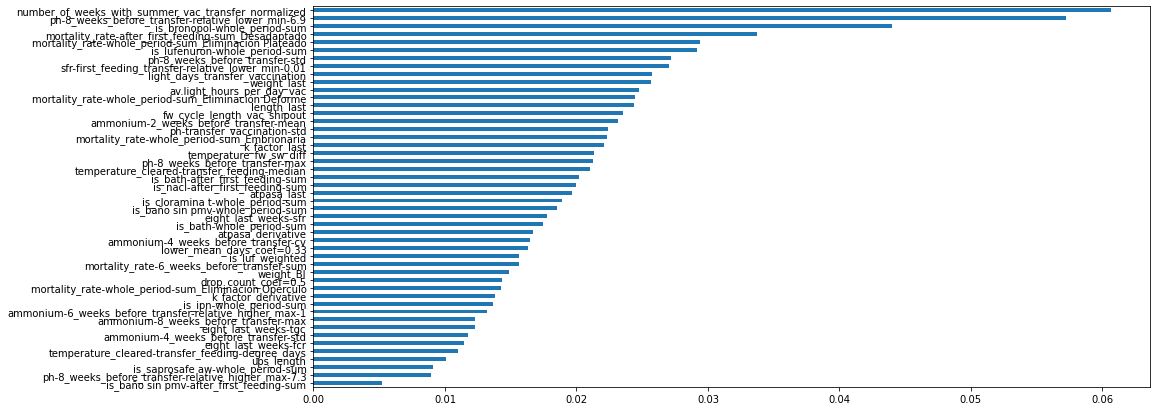

In [10]:
data = train_data
target = 'mortality'
features = all_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data[features])
y_true = test_data[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='train dataset with nans', feature_set_name='all features',
                            target=target)

### 1.2 Train data with filled nans (median)

-0.533158826144134
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


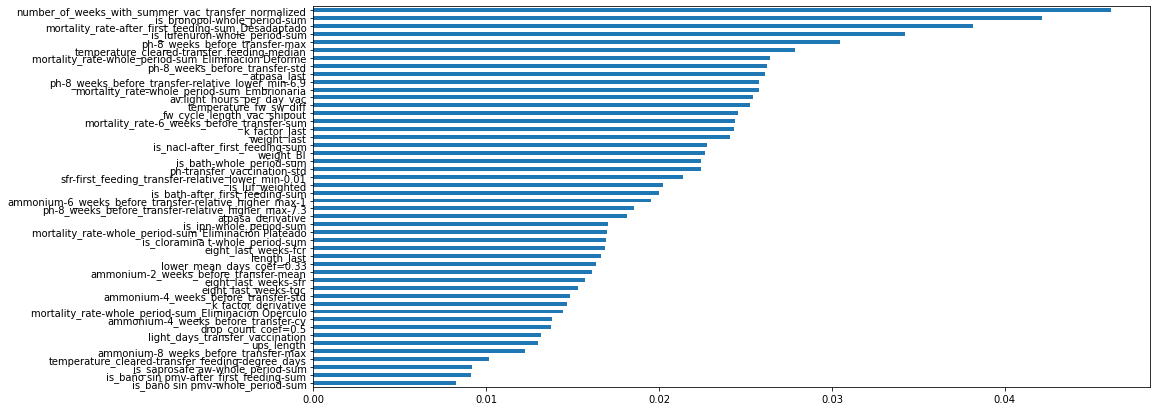

In [11]:
data = train_data_filled
target = 'mortality'
features = all_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data[features])
y_true = test_data[target]


METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='train dataset filled with medians', feature_set_name='all features',
                            target=target)

### 1.3 Scaled data (filled nans)

-0.5351455602633206
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


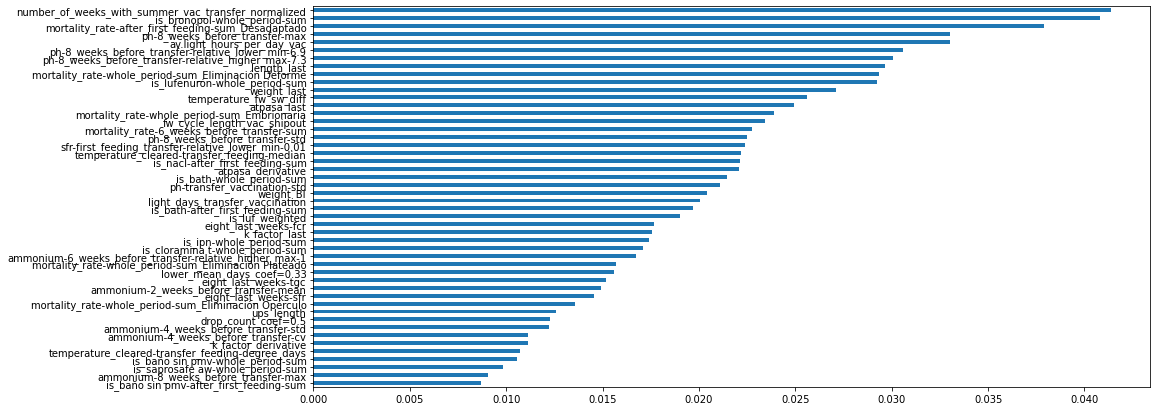

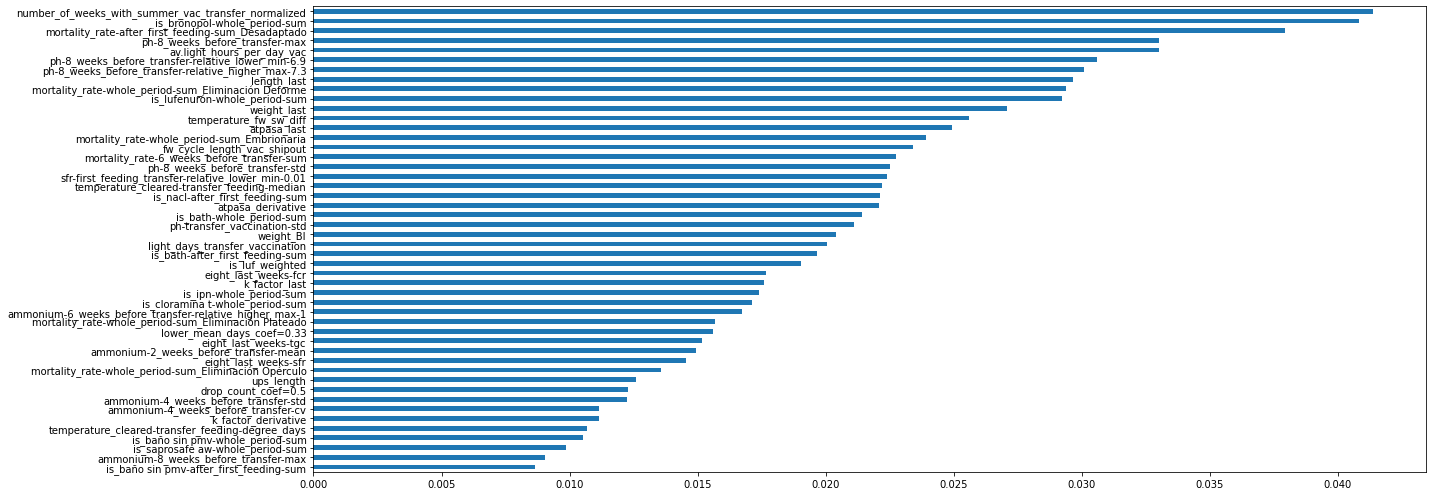

In [12]:
data = train_data_scaled
target = 'mortality'
features = all_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data[features])
y_true = test_data[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='scaled train dataset filled with medians',
                            feature_set_name='all features',
                            target=target)

save_stats(
    pipeline,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix='scaled_filled_data_all_features_model'
)

## 2. Best features for mortality

### 2.1. Train data with nans

-0.5404366375653046
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


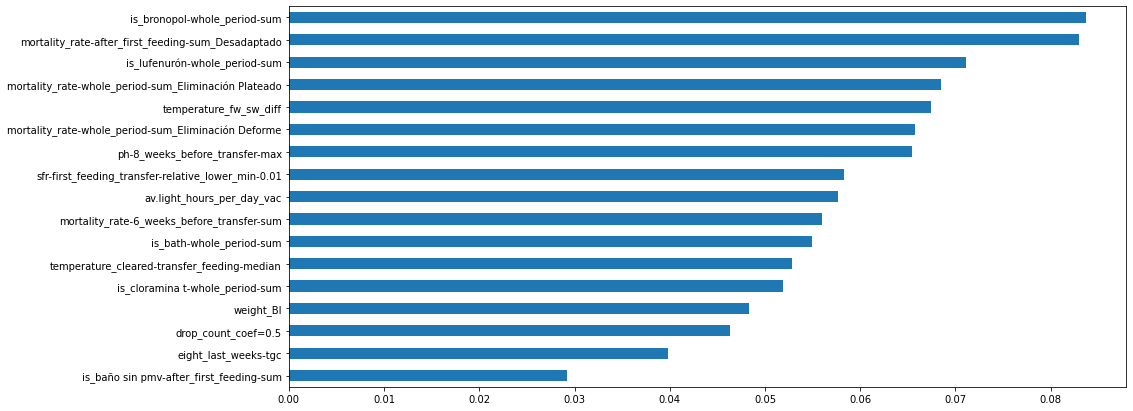

In [13]:
data = train_data
target = 'mortality'
features = final_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data[features])
y_true = test_data[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='train dataset with nans',
                            feature_set_name='final features',
                            target=target)

### 2.2 Train data filled with medians

-0.5442329743113233
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


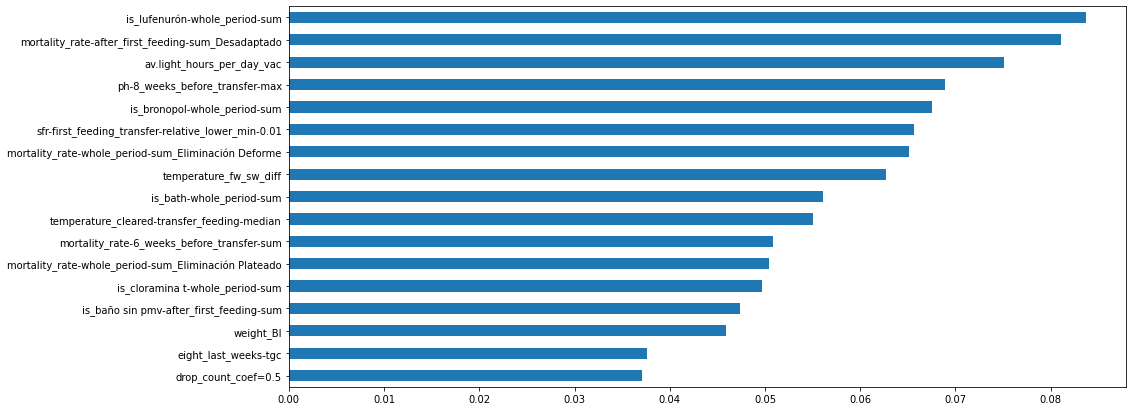

In [14]:
data = train_data_filled
target = 'mortality'
features = final_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data[features])
y_true = test_data[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='train dataset filled with medians',
                            feature_set_name='final features',
                            target=target)

### 2.3 Train data filled with median scaled

-0.5428187033734162
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


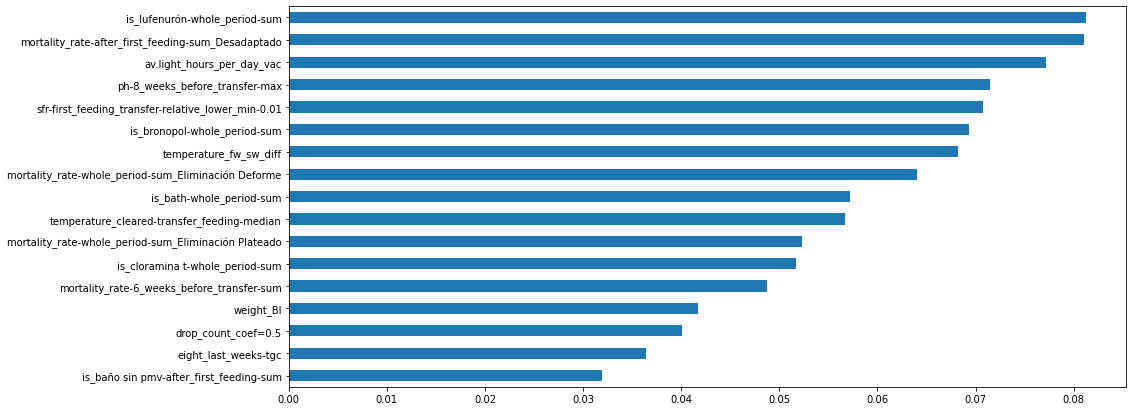

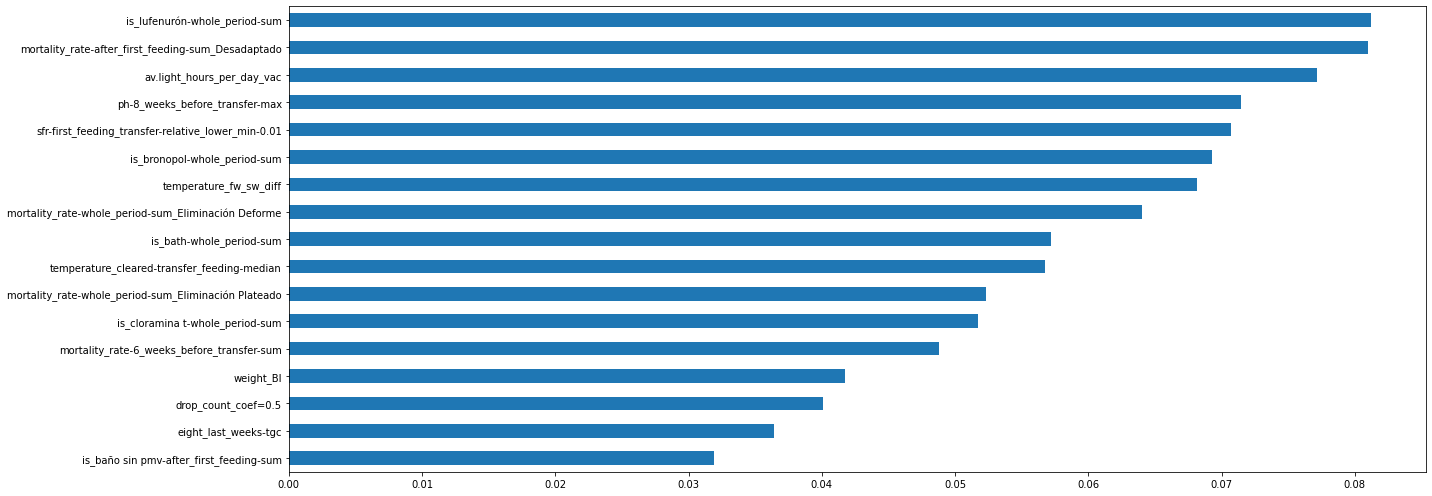

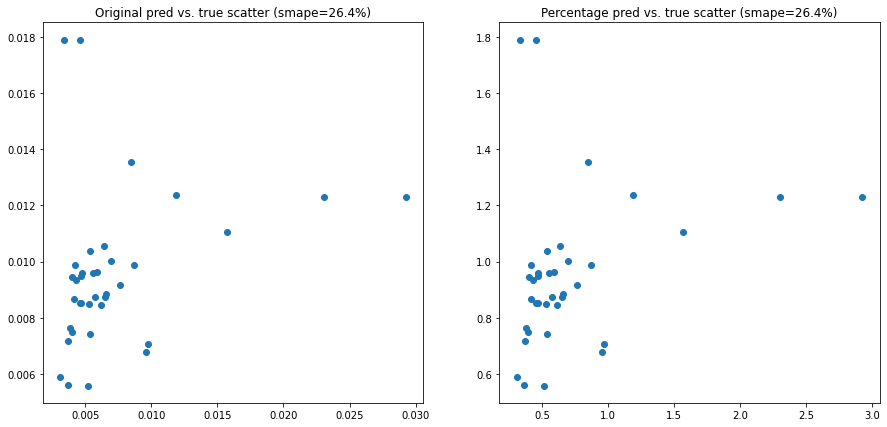

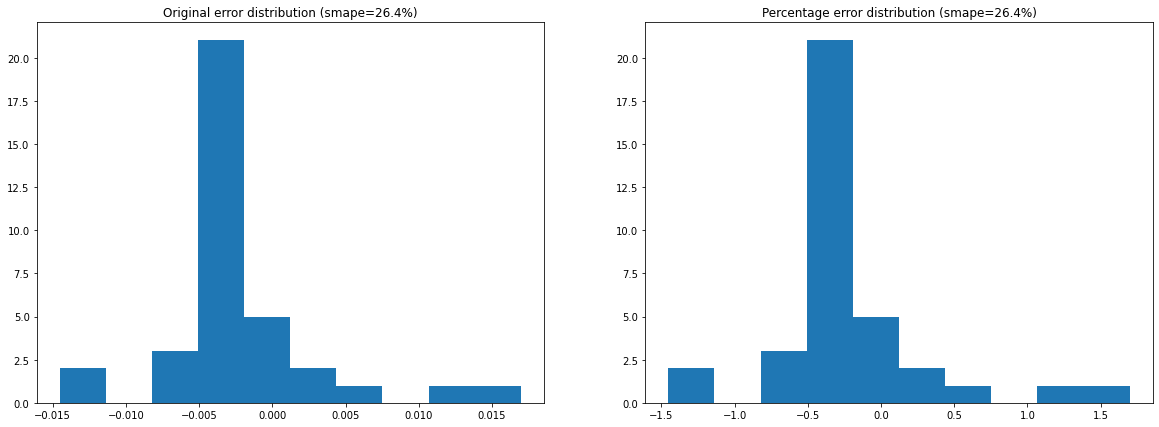

In [15]:
data = train_data_scaled
target = 'mortality'
features = final_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data[features])
y_true = test_data[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='scaled train dataset filled with medians',
                            feature_set_name='final features',
                            target=target)
prefix = 'scaled_filled_data_final_features_model'
save_stats(
    pipeline,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=prefix,
)

y_true_perc = y_true * 100
y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
diff_perc = y_true_perc - y_pred_perc

save_path = img_path / 'predictive' / 'errors'
save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true, y=y_pred)
plt.subplot(1, 2, 2)
plt.title(f"Percentage pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true_perc, y=y_pred_perc)
plt.show()
fig.savefig(f'{save_path}/{prefix}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_original, bins=10)
plt.subplot(1, 2, 2)
plt.title(f"Percentage error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_perc, bins=10)
fig.savefig(f'{save_path}/{prefix}_error_distribution.jpg')

In [16]:
pd.DataFrame(METRICS_SUMMARY)

,train_data,feature_set,target,smape_val,smape,mae,mape,median_true_average_value,median_pred_average_value,std_error
0,train dataset with nans,all features,mortality,19.147327,54.756777,0.014270,265.502761,0.005358,0.019951,0.008072
1,train dataset filled with medians,all features,mortality,19.371946,45.693956,0.010060,188.014456,0.005358,0.014229,0.007550
2,scaled train dataset filled with medians,all features,mortality,19.414041,34.143403,0.006336,112.248392,0.005358,0.010254,0.006387
3,train dataset with nans,final features,mortality,19.327226,39.794995,0.007975,151.929871,0.005358,0.013083,0.006000
4,train dataset filled with medians,final features,mortality,21.374211,24.858418,0.004270,72.069533,0.005358,0.007523,0.005929
5,scaled train dataset filled with medians,final features,mortality,20.330116,26.395025,0.004525,80.649019,0.005358,0.009248,0.005277


### 3. Log mortality target for scaled data on best features

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from panda

-0.09088930661611777
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


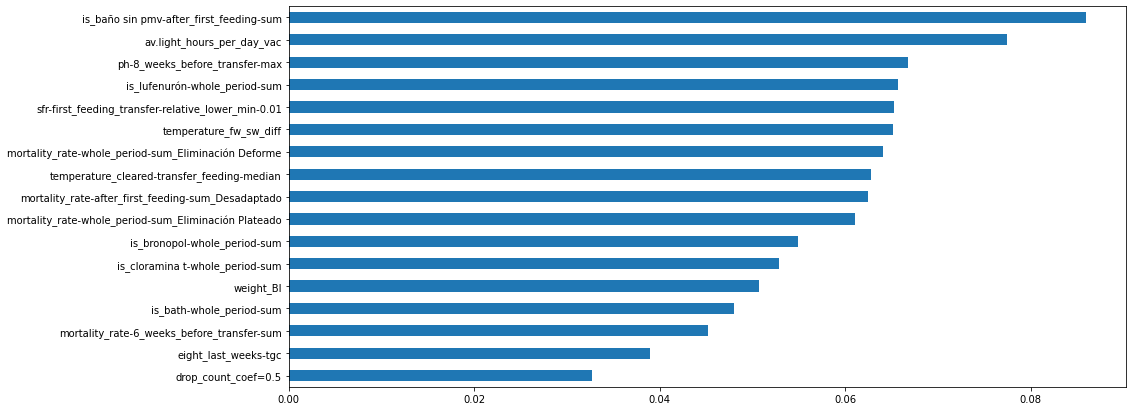

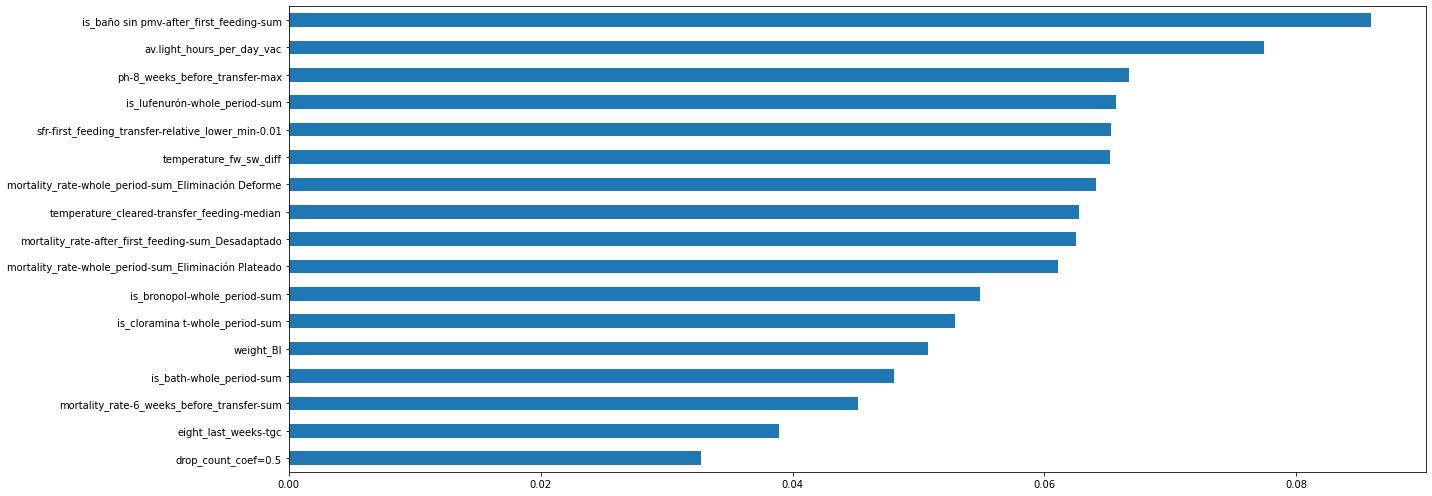

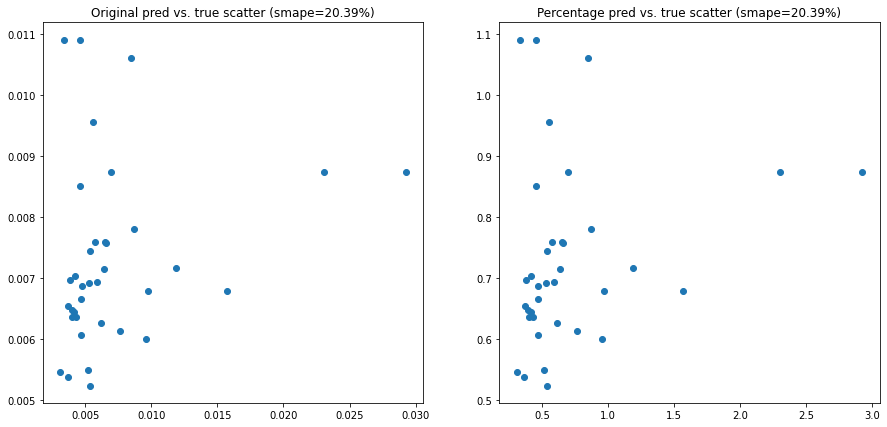

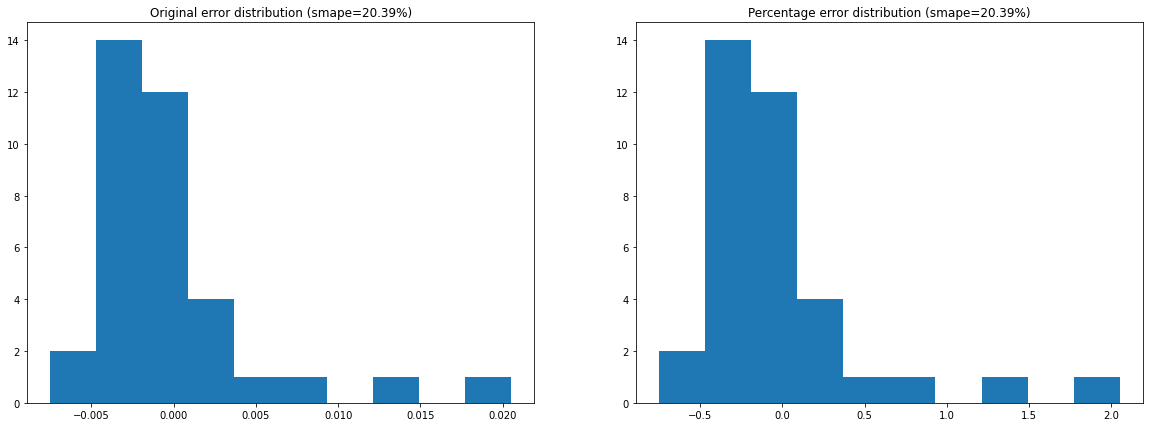

In [47]:
data = train_data_scaled
target = 'log_mortality'
features = final_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = np.exp(pipeline.model_best.predict(test_data[features]))
y_true = test_data['mortality']

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='scaled train dataset filled with medians',
                            feature_set_name='final features',
                            target=target)
prefix = 'scaled_filled_data_final_features_log_mortality_model'
save_stats(
    pipeline,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=prefix
)

y_true_perc = y_true * 100
y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
diff_perc = y_true_perc - y_pred_perc

save_path = img_path / 'predictive' / 'errors'
save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true, y=y_pred)
plt.subplot(1, 2, 2)
plt.title(f"Percentage pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true_perc, y=y_pred_perc)
plt.show()
fig.savefig(f'{save_path}/{prefix}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_original, bins=10)
plt.subplot(1, 2, 2)
plt.title(f"Percentage error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_perc, bins=10)
fig.savefig(f'{save_path}/{prefix}_error_distribution.jpg')

In [18]:
pd.DataFrame(METRICS_SUMMARY)

,train_data,feature_set,target,smape_val,smape,mae,mape,median_true_average_value,median_pred_average_value,std_error
0,train dataset with nans,all features,mortality,19.147327,54.756777,0.014270,265.502761,0.005358,0.019951,0.008072
1,train dataset filled with medians,all features,mortality,19.371946,45.693956,0.010060,188.014456,0.005358,0.014229,0.007550
2,scaled train dataset filled with medians,all features,mortality,19.414041,34.143403,0.006336,112.248392,0.005358,0.010254,0.006387
3,train dataset with nans,final features,mortality,19.327226,39.794995,0.007975,151.929871,0.005358,0.013083,0.006000
4,train dataset filled with medians,final features,mortality,21.374211,24.858418,0.004270,72.069533,0.005358,0.007523,0.005929
5,scaled train dataset filled with medians,final features,mortality,20.330116,26.395025,0.004525,80.649019,0.005358,0.009248,0.005277
6,scaled train dataset filled with medians,final features,log_mortality,18.068770,20.385121,0.003348,48.787466,0.005358,0.006926,0.005184


## 4. Represented / Unrepresented factors from factor ranking

In [19]:
data_path = result_data_path / 'split'
represented_factors_scaled = pd.read_csv(data_path / 'represented_factors.csv')
unrepresented_factors_scaled = pd.read_csv(data_path / 'unrepresented_factors.csv')

represented_factors_scaled = represented_factors_scaled.merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    tgc[key_columns + ['TGC_SW']],
    on=key_columns,
    how='inner'
).merge(
    targets_df[key_columns + ['nSFR']]
)


unrepresented_factors_scaled = unrepresented_factors_scaled.merge(
    mortality[key_columns + ['total_mortality_perc_90']],
    on=key_columns,
    how='inner'
).merge(
    tgc[key_columns + ['TGC_SW']],
    on=key_columns,
    how='inner'
).merge(
    targets_df[key_columns + ['nSFR']]
)

represented_factors_scaled.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
represented_factors_scaled.rename(columns={'TGC_SW': 'tgc'}, inplace=True)
represented_factors_scaled.rename(columns={'nSFR': 'nsfr'}, inplace=True)

unrepresented_factors_scaled.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)
unrepresented_factors_scaled.rename(columns={'TGC_SW': 'tgc'}, inplace=True)
unrepresented_factors_scaled.rename(columns={'nSFR': 'nsfr'}, inplace=True)

represented_factors_scaled['mortality_perc'] = represented_factors_scaled['mortality'] * 100
represented_factors_scaled['log_mortality'] = np.log(represented_factors_scaled['mortality'])
unrepresented_factors_scaled['mortality_perc'] = unrepresented_factors_scaled['mortality'] * 100
unrepresented_factors_scaled['log_mortality'] = np.log(unrepresented_factors_scaled['mortality'])

test_data['mortality_perc'] = test_data['mortality'] * 100
test_data['log_mortality'] = np.log(test_data['mortality'])

targets = ['mortality', 'mortality_perc', 'log_mortality', 'tgc', 'nsfr']

train_data_represented = represented_factors_scaled[represented_factors_scaled['transfer_year'] != 2023]
test_data_represented = represented_factors_scaled[represented_factors_scaled['transfer_year'] == 2023]

train_data_unrepresented = unrepresented_factors_scaled[unrepresented_factors_scaled['transfer_year'] != 2023]
test_data_unrepresented = unrepresented_factors_scaled[unrepresented_factors_scaled['transfer_year'] == 2023]

### 4.1 Represented dataset all features mortality target

-0.5292975386193561
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


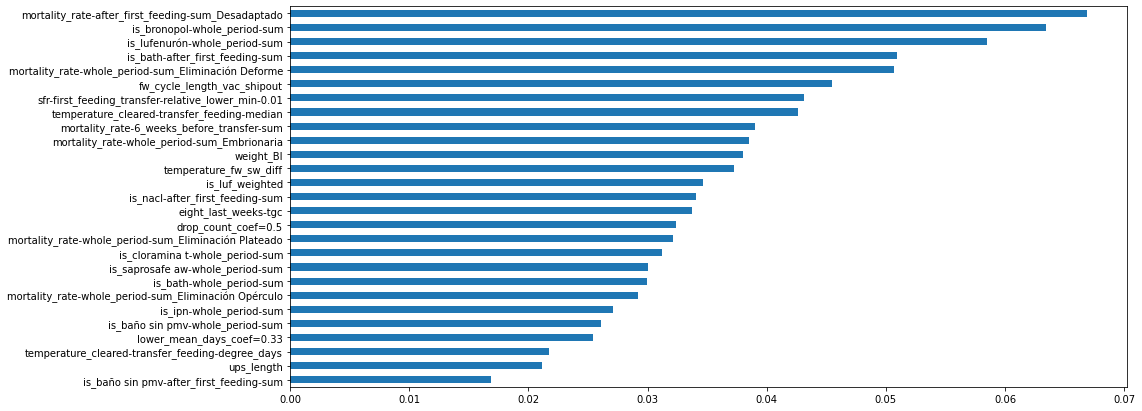

In [20]:
data = train_data_represented
target = 'mortality'
features = train_data_represented.columns.difference(key_columns).difference(targets)

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data_represented[features])
y_true = test_data_represented[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='represented dataset',
                            feature_set_name='well represented features',
                            target=target)

### 4.2 Represented dataset final features mortality target

-0.5579574935347322
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


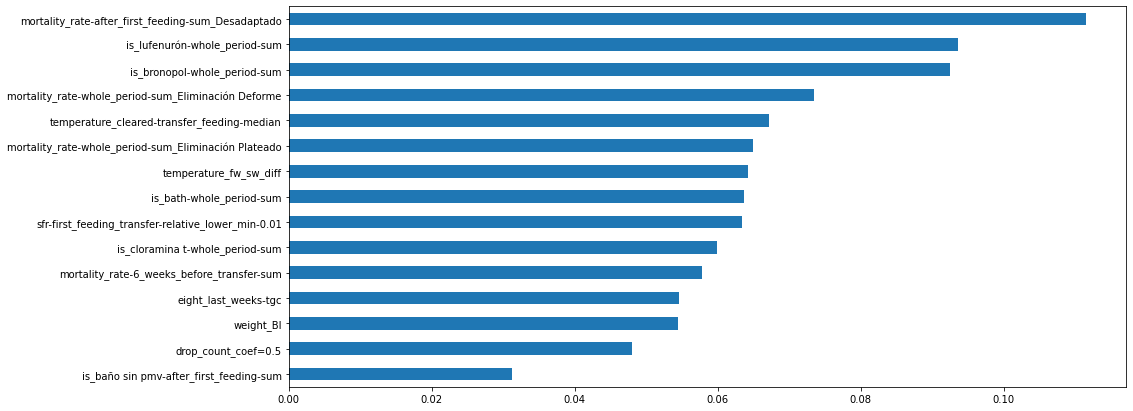

In [21]:
data = train_data_represented
target = 'mortality'
to_exclude = ['av.light_hours_per_day_vac', 'ph-8_weeks_before_transfer-max']
features = [f for f in final_features if f not in to_exclude]

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data_represented[features])
y_true = test_data_represented[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='represented dataset',
                            feature_set_name='final features except av.light and ph',
                            target=target)

### 4.3 Represented dataset final features log mortality target

-0.09197405466899312
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


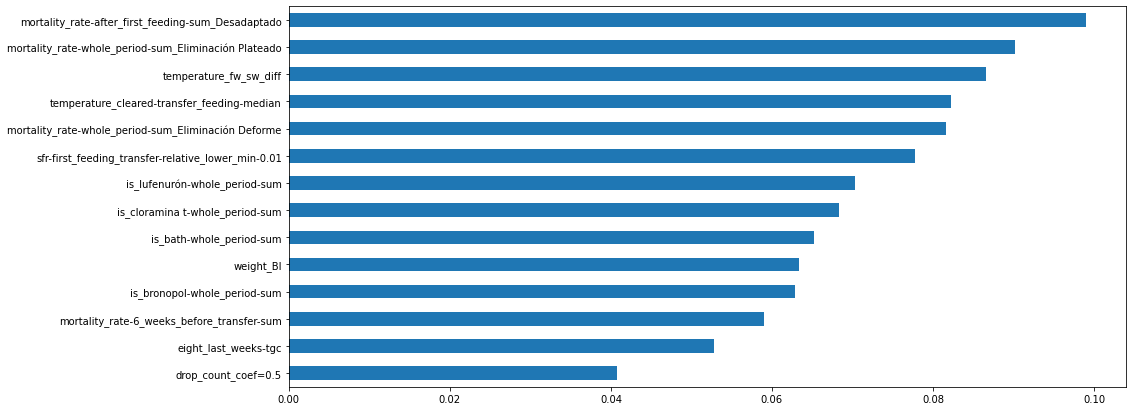

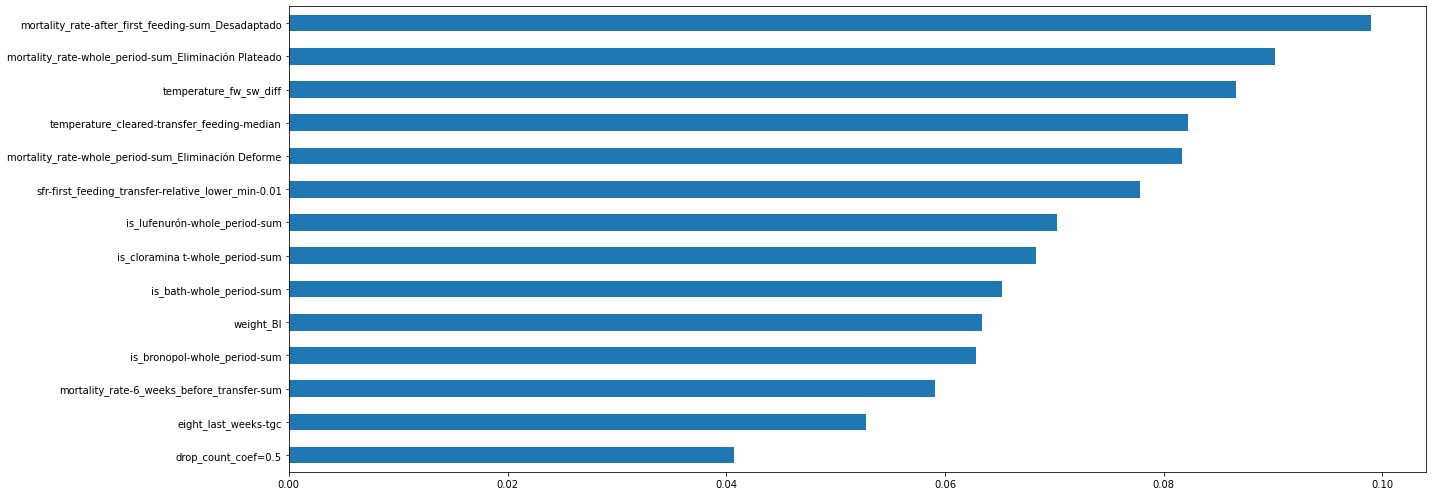

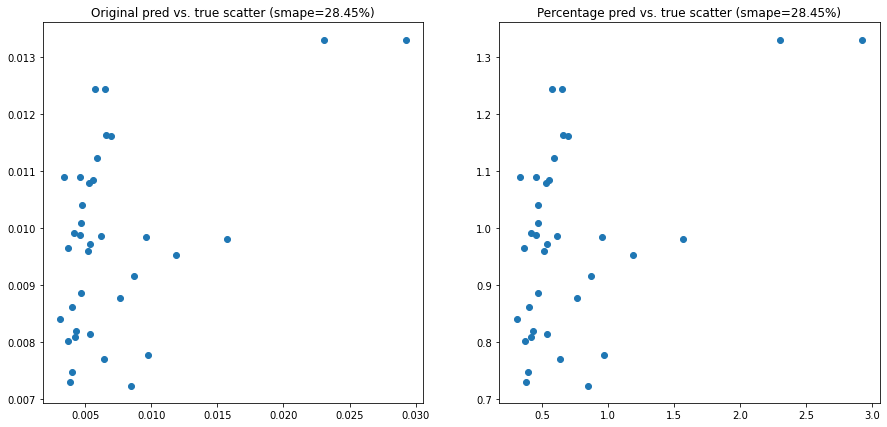

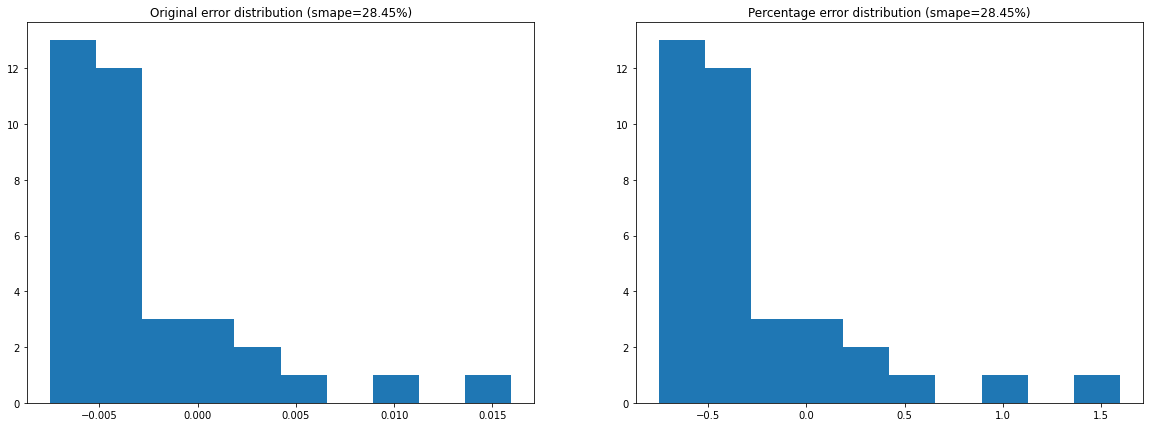

In [22]:
data = train_data_represented
target = 'log_mortality'
to_exclude = ['av.light_hours_per_day_vac', 'ph-8_weeks_before_transfer-max',
              'is_baño sin pmv-after_first_feeding-sum',
              'is_baño sin pmv-whole_period-sum'
             ]
features = [f for f in final_features if f not in to_exclude]

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = np.exp(pipeline.model_best.predict(test_data_represented[features]))
y_true = test_data_represented['mortality']

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='represented dataset',
                            feature_set_name='final features except av.light, ph and is_baño',
                            target=target)

prefix = 'represented_dataset_final_features_except_av.light_ph_is_bano_mortality_model'
save_stats(
    pipeline,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=prefix
)

y_true_perc = y_true * 100
y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
diff_perc = y_true_perc - y_pred_perc

save_path = img_path / 'predictive' / 'errors'
save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true, y=y_pred)
plt.subplot(1, 2, 2)
plt.title(f"Percentage pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true_perc, y=y_pred_perc)
plt.show()
fig.savefig(f'{save_path}/{prefix}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_original, bins=10)
plt.subplot(1, 2, 2)
plt.title(f"Percentage error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_perc, bins=10)
fig.savefig(f'{save_path}/{prefix}_error_distribution.jpg')

### 4.4 Unrepresented dataset all features mortality target

-0.7479991517351297
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


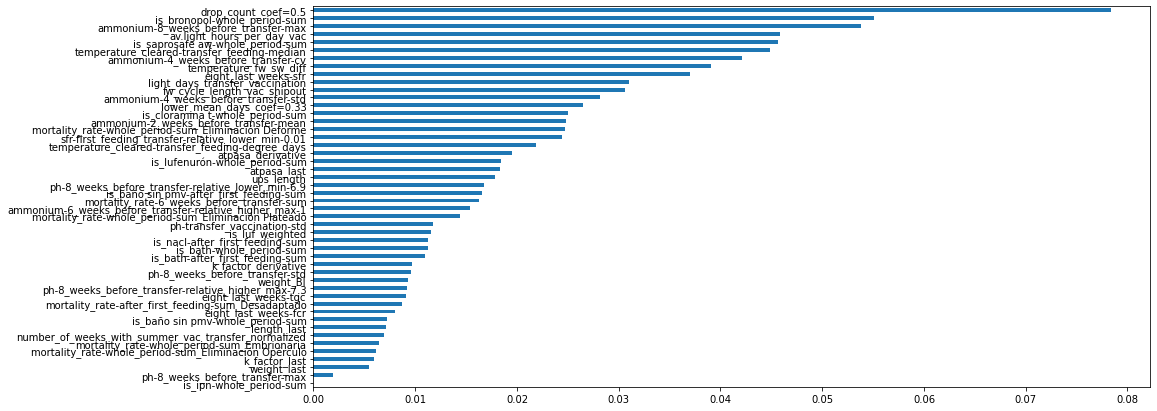

In [23]:
data = train_data_unrepresented
target = 'mortality'
features = all_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data_unrepresented[features])
y_true = test_data_unrepresented[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='unrepresented dataset',
                            feature_set_name='all features',
                            target=target)

### 4.5 Unrepresented dataset final features mortality target

-0.6800224600289339
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


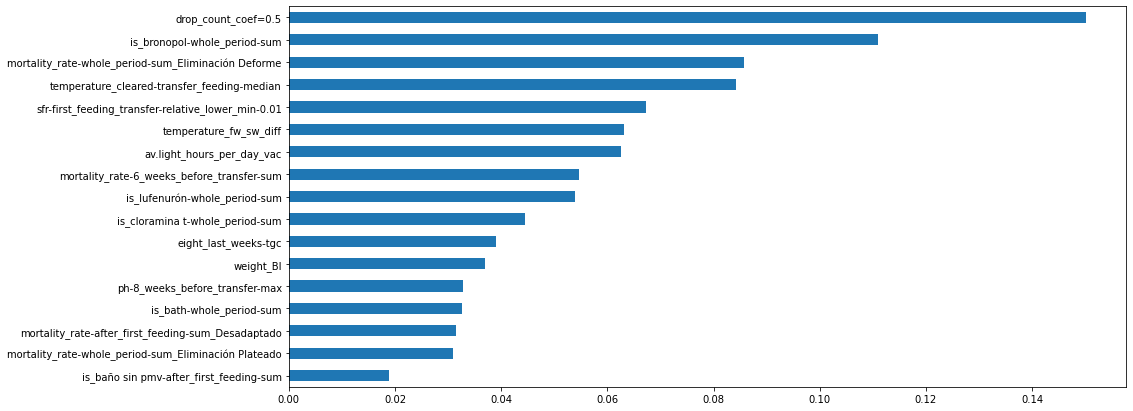

In [24]:
data = train_data_unrepresented
target = 'mortality'
features = final_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = pipeline.model_best.predict(test_data_unrepresented[features])
y_true = test_data_unrepresented[target]

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='unrepresented dataset',
                            feature_set_name='final features',
                            target=target)

### 4.6 Unrepresented dataset final features mortality log target

-0.11020803577118238
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


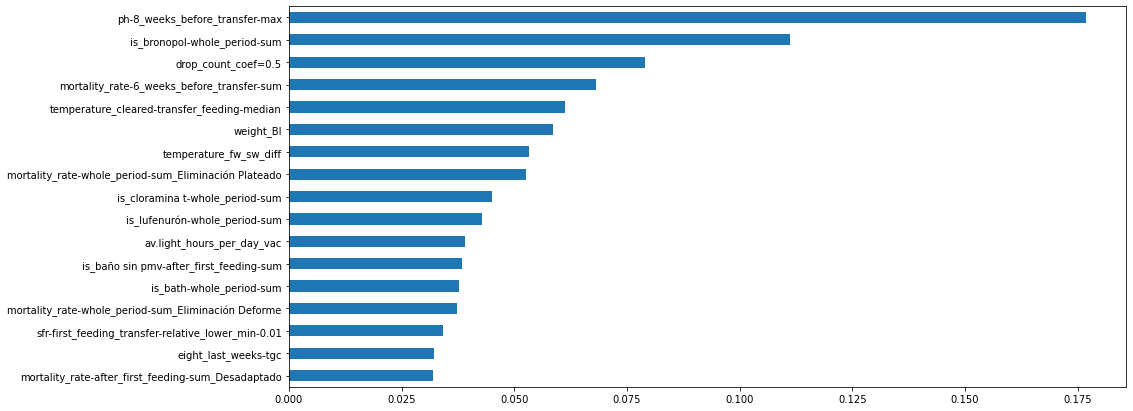

In [25]:
data = train_data_unrepresented
target = 'log_mortality'
features = final_features

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = np.exp(pipeline.model_best.predict(test_data_unrepresented[features]))
y_true = test_data_unrepresented['mortality']

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='unrepresented dataset',
                            feature_set_name='final features',
                            target=target)

### 5.7 Unrepresented + Represented model blanding

-0.09197405466899312
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}
-0.11097922675368785
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


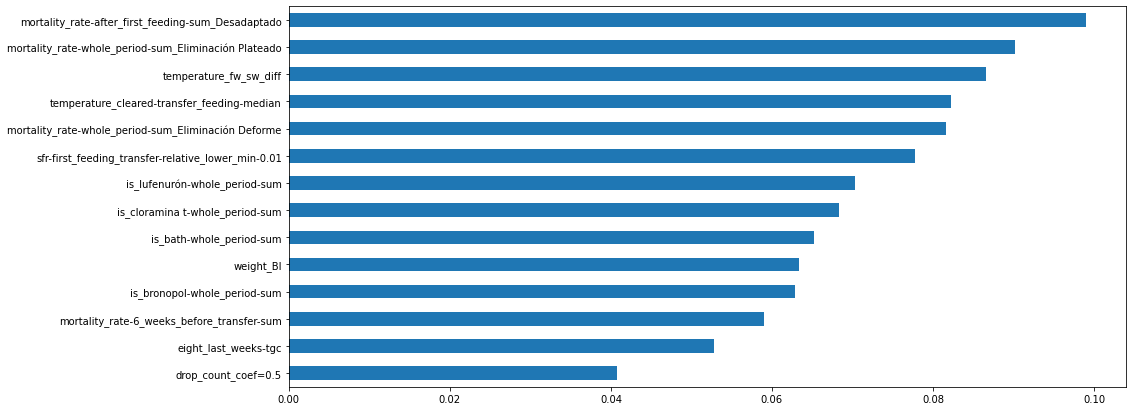

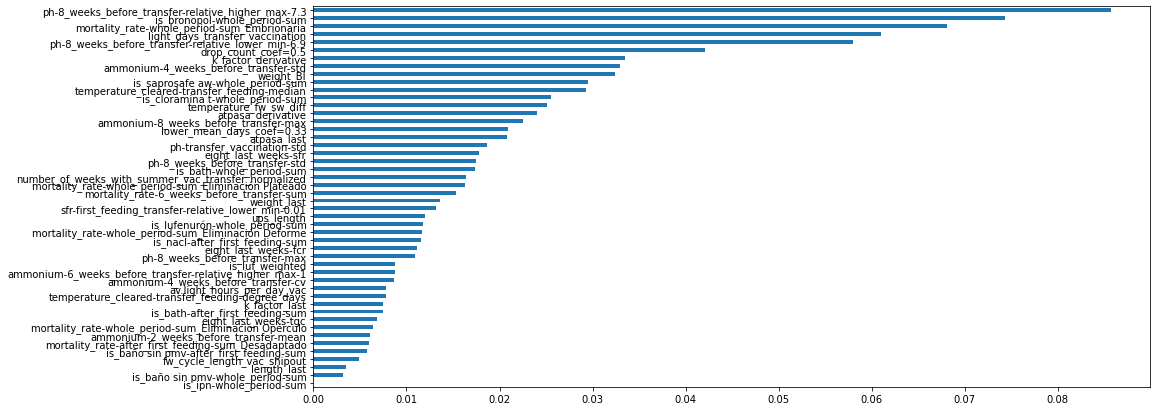

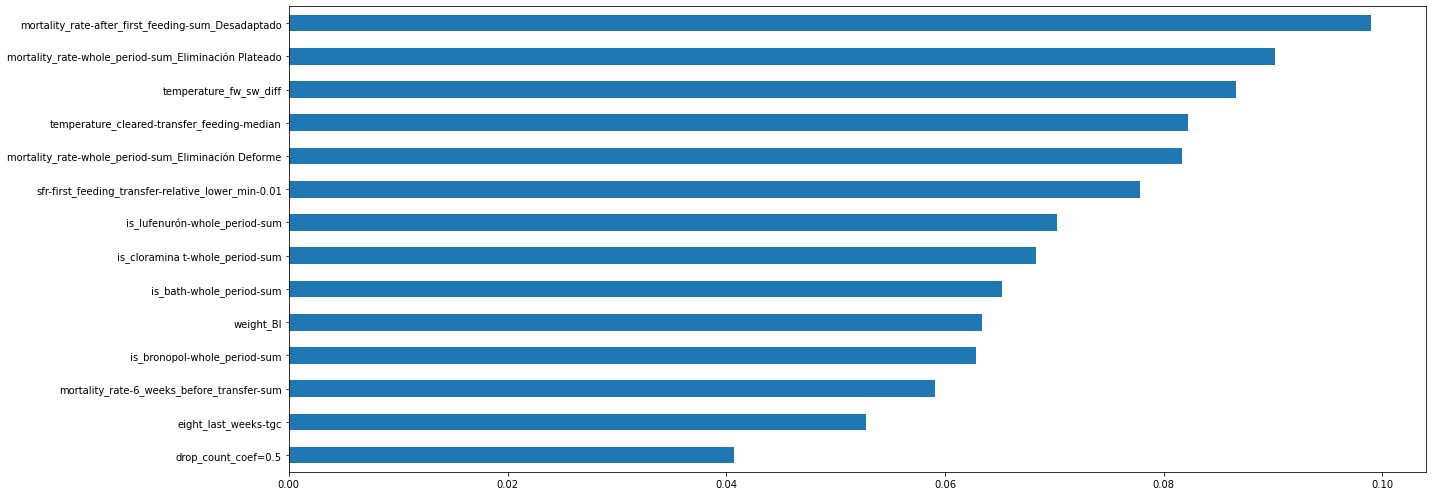

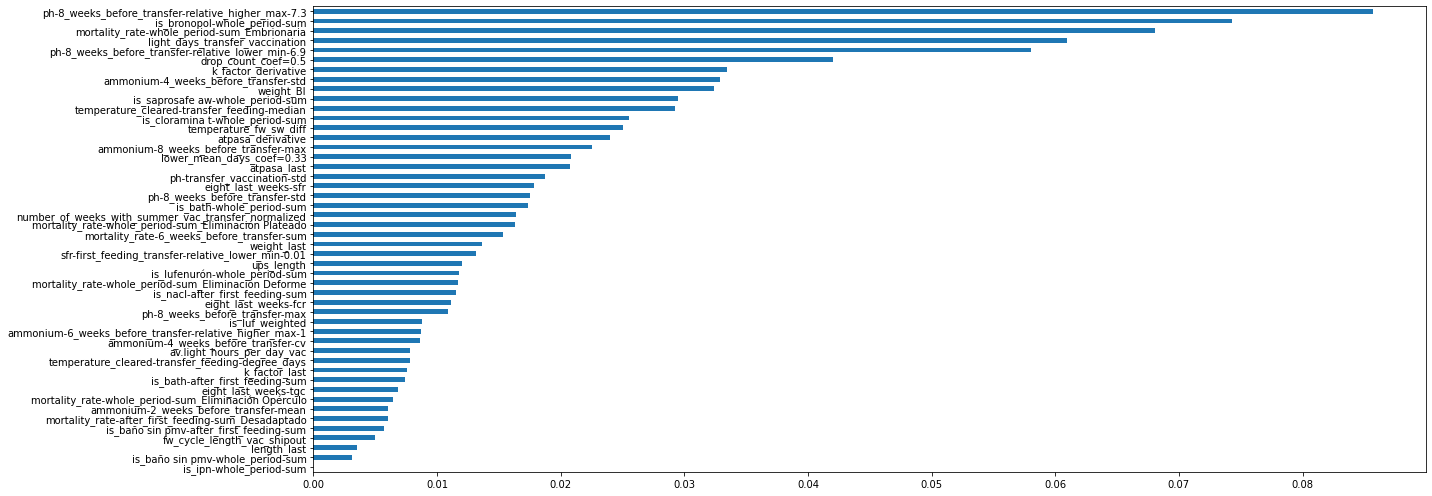

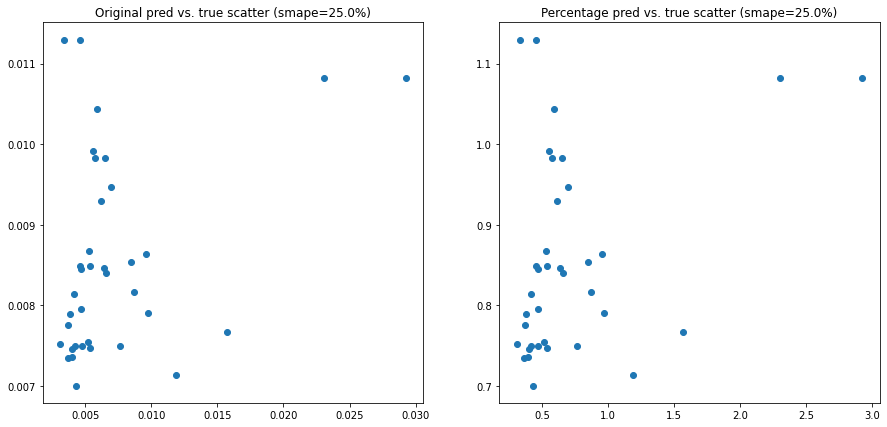

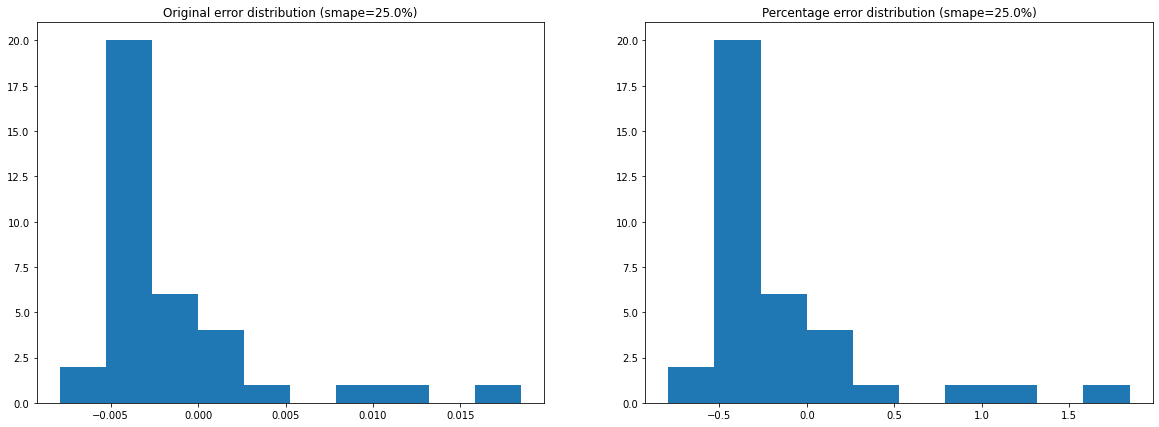

In [26]:
frac = train_data_represented.shape[0] / train_data_unrepresented.shape[1]

data = train_data_represented
target = 'log_mortality'
to_exclude = ['av.light_hours_per_day_vac', 'ph-8_weeks_before_transfer-max',
              'is_baño sin pmv-after_first_feeding-sum',
              'is_baño sin pmv-whole_period-sum'
]
features = [f for f in final_features if f not in to_exclude]

pipeline_represented = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline_represented.process()

y_pred_represented = np.exp(pipeline_represented.model_best.predict(test_data[features]))

data = train_data_unrepresented
target = 'log_mortality'
features = all_features

pipeline_unrepresented = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline_unrepresented.process()

y_pred_unrepresented = np.exp(pipeline_unrepresented.model_best.predict(test_data[features]))

y_true = test_data['mortality']
y_pred = (y_pred_unrepresented + frac * y_pred_represented) / (frac + 1)
smape_val = (frac * pipeline_represented.smape_val + pipeline_unrepresented.smape_val) / (frac + 1)

METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='represented and unrepresented dataset (2 models blend)',
                            feature_set_name='final features except av.light, ph and is_baño and all features (2 models blend)',
                            target=target)



prefix = 'represented_model_from_blend_on_final_features_except_av.light_ph_is_bano_log_mortality'
save_stats(
    pipeline_represented,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=prefix
)

prefix = 'unrepresented_model_from_blend_on_all_features_log_mortality'
save_stats(
    pipeline_unrepresented,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=prefix
)


prefix = 'represented_unrepresented_model_blend_log_mortality'

y_true_perc = y_true * 100
y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
diff_perc = y_true_perc - y_pred_perc

save_path = img_path / 'predictive' / 'errors'
save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true, y=y_pred)
plt.subplot(1, 2, 2)
plt.title(f"Percentage pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true_perc, y=y_pred_perc)
plt.show()
fig.savefig(f'{save_path}/{prefix}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_original, bins=10)
plt.subplot(1, 2, 2)
plt.title(f"Percentage error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_perc, bins=10)
fig.savefig(f'{save_path}/{prefix}_error_distribution.jpg')

In [27]:
pd.DataFrame(METRICS_SUMMARY)

,train_data,feature_set,target,smape_val,smape,mae,mape,median_true_average_value,median_pred_average_value,std_error
0,train dataset with nans,all features,mortality,19.147327,54.756777,0.014270,265.502761,0.005358,0.019951,0.008072
1,train dataset filled with medians,all features,mortality,19.371946,45.693956,0.010060,188.014456,0.005358,0.014229,0.007550
2,scaled train dataset filled with medians,all features,mortality,19.414041,34.143403,0.006336,112.248392,0.005358,0.010254,0.006387
3,train dataset with nans,final features,mortality,19.327226,39.794995,0.007975,151.929871,0.005358,0.013083,0.006000
4,train dataset filled with medians,final features,mortality,21.374211,24.858418,0.004270,72.069533,0.005358,0.007523,0.005929
5,scaled train dataset filled with medians,final features,mortality,20.330116,26.395025,0.004525,80.649019,0.005358,0.009248,0.005277
6,scaled train dataset filled with medians,final features,log_mortality,18.068770,20.385121,0.003348,48.787466,0.005358,0.006926,0.005184
7,represented dataset,well represented features,mortality,19.161546,45.590181,0.009859,188.287521,0.005358,0.015554,0.006722
8,represented dataset,final features except av.light and ph,mortality,20.390307,34.569686,0.006321,117.825004,0.005358,0.011248,0.005203
9,represented dataset,"final features except av.light, ph and is_baño",log_mortality,17.697720,28.447274,0.004702,83.897612,0.005358,0.009765,0.004765


## 5. Best model improvement

In [29]:
pd.DataFrame(METRICS_SUMMARY)[pd.DataFrame(METRICS_SUMMARY)['smape'] == pd.DataFrame(METRICS_SUMMARY)['smape'].min()]

,train_data,feature_set,target,smape_val,smape,mae,mape,median_true_average_value,median_pred_average_value,std_error
6,scaled train dataset filled with medians,final features,log_mortality,18.06877,20.385121,0.003348,48.787466,0.005358,0.006926,0.005184


/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from panda

-0.09088930661611777
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


,smape,mae,mape,median_true_average_value,median_pred_average_value,std_error
0,20.385121,0.003348,48.787466,0.005358,0.006926,0.005184


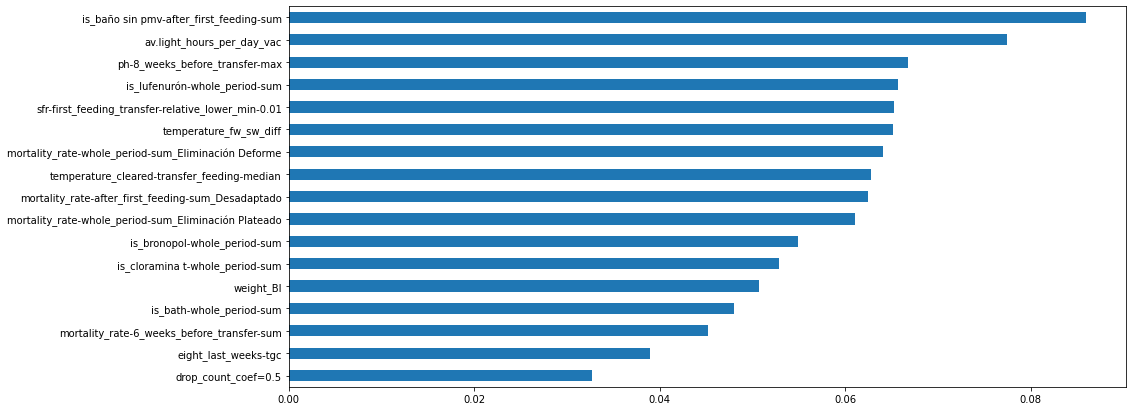

In [43]:
# best model train again

data = train_data_scaled
target = 'log_mortality'
features = final_features

baseline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
baseline.process()

y_pred = np.exp(baseline.model_best.predict(test_data[features]))
y_true = test_data['mortality']

metrics = {
    'smape': smape(y_true, y_pred),
    'mae': mean_absolute_error(y_true, y_pred),
    'mape': mape(y_true, y_pred),
    'median_true_average_value': np.median(y_true),
    'median_pred_average_value': np.median(y_pred),
    'std_error': np.std(y_true - y_pred)
}

display(pd.DataFrame(metrics, index=[0]))

### Narrowing down to 10 best features

-0.09851318846393405
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7, 'verbosity': 0}


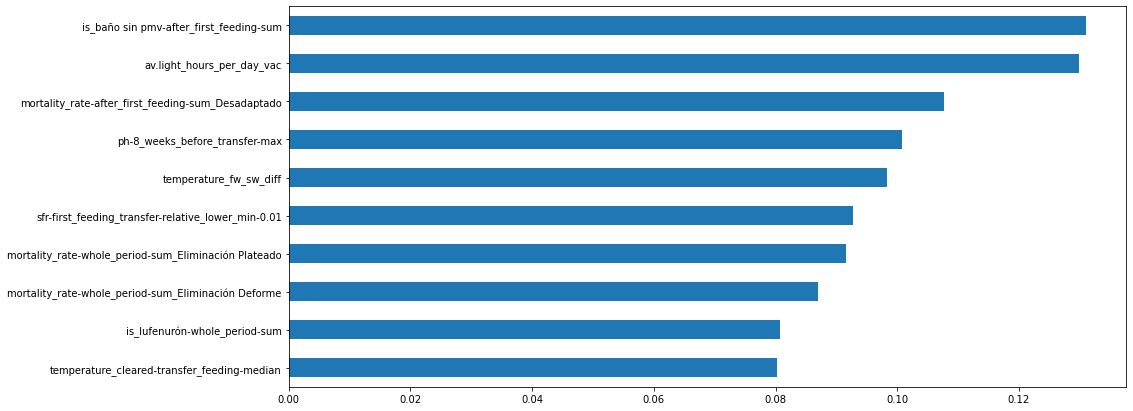

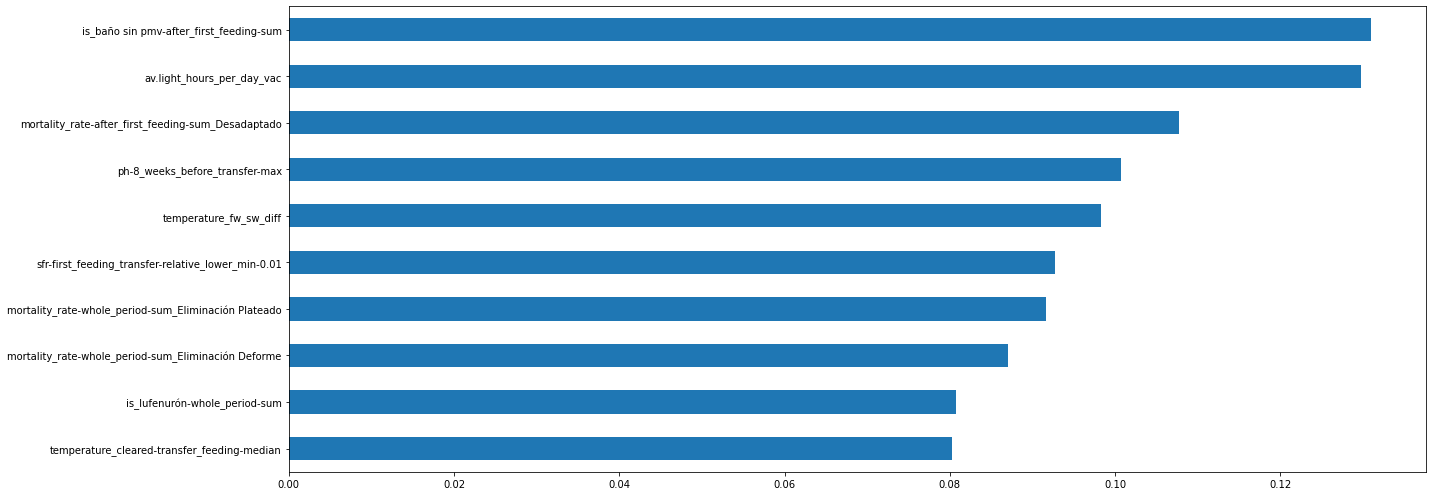

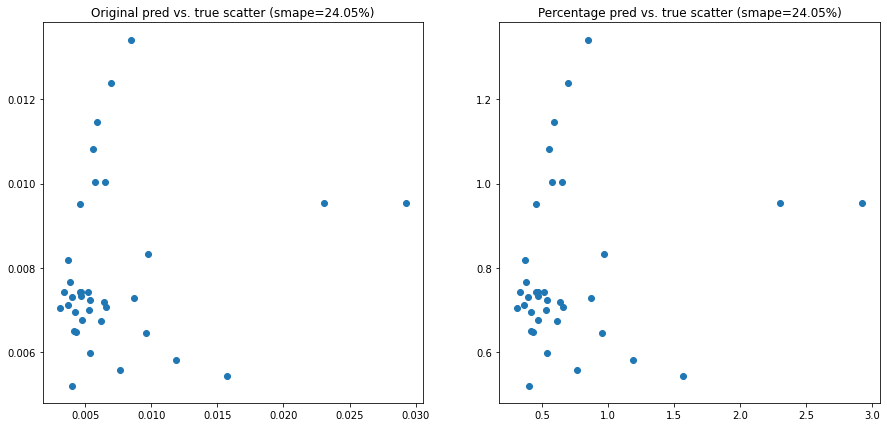

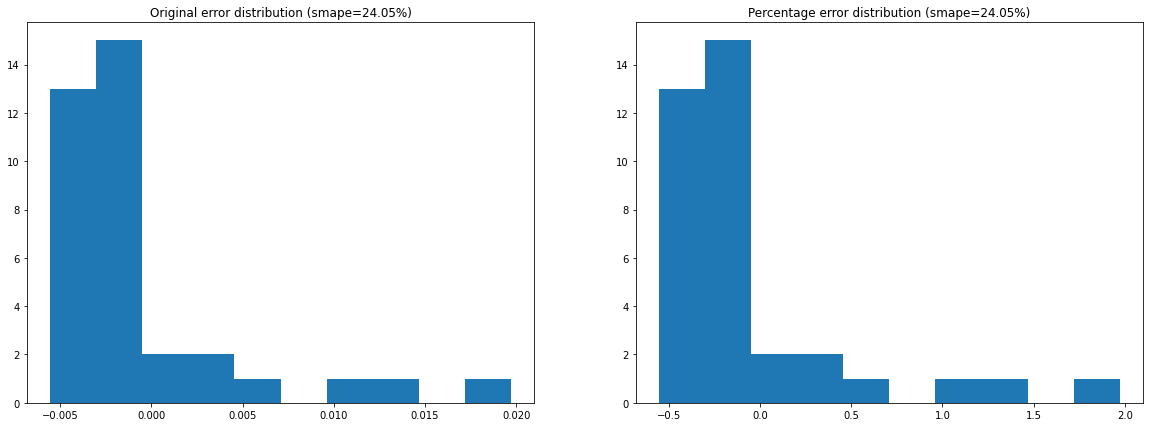

In [44]:
# best model train again

data = train_data_scaled
target = 'log_mortality'
features = baseline.model_factors.sort_values(ascending=False)[:10].index

pipeline = ModelPipeline(
    data=data,
    features=features,
    target=target,
    model = xgb.XGBRegressor
)
pipeline.process()

y_pred = np.exp(pipeline.model_best.predict(test_data[features]))
y_true = test_data['mortality']


METRICS_SUMMARY = fill_dict(d=METRICS_SUMMARY, smape_val=pipeline.smape_val, y_true=y_true, y_pred=y_pred,
                            dataset_name='scaled train dataset filled with medians',
                            feature_set_name='top 10 among final features by best smape xgboost',
                            target=target)
prefix = 'scaled_filled_data_final_features_log_mortality_model'
save_stats(
    pipeline,
    save_path=result_data_path / 'predictive',
    img_save_path=img_path / 'importance',
    prefix=prefix
)

y_true_perc = y_true * 100
y_pred_perc = y_pred * 100

diff_original = y_true - y_pred
diff_perc = y_true_perc - y_pred_perc

save_path = img_path / 'predictive' / 'errors'
save_path.mkdir(exist_ok=True)

fig = plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true, y=y_pred)
plt.subplot(1, 2, 2)
plt.title(f"Percentage pred vs. true scatter (smape={round(smape(y_true, y_pred), 2)}%)")
plt.scatter(x=y_true_perc, y=y_pred_perc)
plt.show()
fig.savefig(f'{save_path}/{prefix}_prediction_scatter.jpg')

fig = plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
plt.title(f"Original error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_original, bins=10)
plt.subplot(1, 2, 2)
plt.title(f"Percentage error distribution (smape={round(smape(y_true, y_pred), 2)}%)")
plt.hist(diff_perc, bins=10)
fig.savefig(f'{save_path}/{prefix}_error_distribution.jpg')

In [46]:
pd.DataFrame(METRICS_SUMMARY).to_csv(f'{PREDICTIVE_SAVE_PATH}/metrics_summary.csv', index=False)

As we can see, narrowing down features list didn't improve models prediction accuracy, so we stick with the base set